In [1]:
import os
import time
import re
import nltk
import pandas as pd
import numpy as np
import torch
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import AutoTokenizer, AutoModel
from sklearn.base import BaseEstimator, TransformerMixin

# -----------------------
# Load environment variables
# -----------------------
load_dotenv()

# -----------------------
# Download NLTK stopwords
# -----------------------
#nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

In [2]:
def preprocess_text(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in text.split() if word not in stop_words or len(word) > 1]
    return " ".join(tokens)

In [3]:
# -----------------------
# Traditional Similarity Methods
# -----------------------
class TraditionalSimilarity:
    def __init__(self):
        # Initialize TF-IDF vectorizer with parameters that avoid an empty vocabulary.
        self.tfidf_vectorizer = TfidfVectorizer(min_df=1, stop_words=None, lowercase=False, token_pattern=r'\S+')
    
    def jaccard_similarity(self, q1, q2):
        words1 = set(q1.split())
        words2 = set(q2.split())
        intersection = len(words1.intersection(words2))
        union = len(words1.union(words2))
        return intersection / union if union != 0 else 0

    def tfidf_cosine_similarity(self, q1, q2):
        if not q1.strip() or not q2.strip():
            return 0.0
        try:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform([q1, q2])
            return sk_cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        except ValueError:
            # Return 0 similarity if vocabulary is empty
            return 0.0


    def levenshtein_similarity(self, s1, s2):
        m, n = len(s1), len(s2)
        dp = np.zeros((m+1, n+1), dtype=int)
        for i in range(m+1):
            dp[i][0] = i
        for j in range(n+1):
            dp[0][j] = j
        for i in range(1, m+1):
            for j in range(1, n+1):
                if s1[i-1] == s2[j-1]:
                    dp[i][j] = dp[i-1][j-1]
                else:
                    dp[i][j] = 1 + min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1])
        max_len = max(m, n)
        return 1 - (dp[m][n] / max_len) if max_len != 0 else 0

In [ ]:
# -----------------------
# AI-Enhanced Similarity using HuggingFace all-mpnet-base-v2
# -----------------------
class AIEnhancedSimilarity:
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2'):
        # Load the tokenizer and model directly from HuggingFace Hub.
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def semantic_similarity(self, q1, q2):
        # Tokenize and prepare inputs for both questions.
        inputs = self.tokenizer([q1, q2], padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.model(**inputs)
        # Mean pool the token embeddings (ignoring padding).
        embeddings = outputs.last_hidden_state.mean(dim=1)
        emb1 = embeddings[0].cpu().numpy()
        emb2 = embeddings[1].cpu().numpy()
        # Calculate cosine similarity.
        cosine = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        return cosine

In [5]:
# -----------------------
# Custom Transformer for Feature Extraction
# -----------------------
class SimilarityFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.trad_sim = TraditionalSimilarity()
        self.ai_sim = AIEnhancedSimilarity()  # Using the HuggingFace model for semantic similarity

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        features = []
        for _, row in X.iterrows():
            q1, q2 = row['question1'], row['question2']
            try:
                features.append([
                    self.trad_sim.jaccard_similarity(q1, q2),
                    self.trad_sim.tfidf_cosine_similarity(q1, q2),
                    self.trad_sim.levenshtein_similarity(q1, q2),
                    self.ai_sim.semantic_similarity(q1, q2)
                ])
            except Exception as e:
                print(f"Error processing row: {e}")
                features.append([0, 0, 0, 0])  # Default values
        return np.array(features)


In [6]:
# -----------------------
# Data Loading & Preprocessing
# -----------------------
sample_size = 20000  # Adjust sample size as needed.
df = pd.read_csv('train.csv', nrows=sample_size)
df['question1'] = df['question1'].apply(preprocess_text)
df['question2'] = df['question2'].apply(preprocess_text)

# -----------------------
# Feature Extraction
# -----------------------
print("Extracting features...")
feature_extractor = SimilarityFeatureExtractor()
X = feature_extractor.transform(df)
y = df['is_duplicate'].values

Extracting features...


In [7]:
# -----------------------
# Evaluate Individual Similarity Methods
# -----------------------
print("Calculating individual similarity accuracies...")

jaccard_pred = X[:, 0] > 0.5
tfidf_pred = X[:, 1] > 0.5
levenshtein_pred = X[:, 2] > 0.5
semantic_pred = X[:, 3] > 0.5

from sklearn.metrics import accuracy_score
jaccard_acc = accuracy_score(y, jaccard_pred)
tfidf_acc = accuracy_score(y, tfidf_pred)
levenshtein_acc = accuracy_score(y, levenshtein_pred)
semantic_acc = accuracy_score(y, semantic_pred)

print(f"\nAccuracies for each similarity method:")
print(f"Jaccard Similarity: {jaccard_acc:.4f}")
print(f"TF-IDF Cosine Similarity: {tfidf_acc:.4f}")
print(f"Levenshtein Similarity: {levenshtein_acc:.4f}")
print(f"Semantic Similarity (HuggingFace): {semantic_acc:.4f}")

Calculating individual similarity accuracies...

Accuracies for each similarity method:
Jaccard Similarity: 0.6447
TF-IDF Cosine Similarity: 0.6489
Levenshtein Similarity: 0.6634
Semantic Similarity (HuggingFace): 0.6355


In [8]:
# -----------------------
# Prepare Features, Split Data, and Train a Binary Classifier
# -----------------------
# For demonstration, we use all four features.
features = ['jaccard_sim', 'tfidf_cosine', 'levenshtein_sim', 'semantic_sim']
X_features = pd.DataFrame({
    'jaccard_sim': [row[0] for row in X],
    'tfidf_cosine': [row[1] for row in X],
    'levenshtein_sim': [row[2] for row in X],
    'semantic_sim': [row[3] for row in X]
})
y_labels = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
combined_acc = accuracy_score(y_test, y_pred)
print(f"\nCombined Model Accuracy: {combined_acc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2495
           1       0.74      0.75      0.74      1505

    accuracy                           0.81      4000
   macro avg       0.79      0.80      0.80      4000
weighted avg       0.81      0.81      0.81      4000


Confusion Matrix:
[[2106  389]
 [ 381 1124]]

Combined Model Accuracy: 0.8075


In [9]:
# -----------------------
# Feature Importance
# -----------------------
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
           feature  importance
3     semantic_sim    0.522888
2  levenshtein_sim    0.194551
0      jaccard_sim    0.156162
1     tfidf_cosine    0.126399


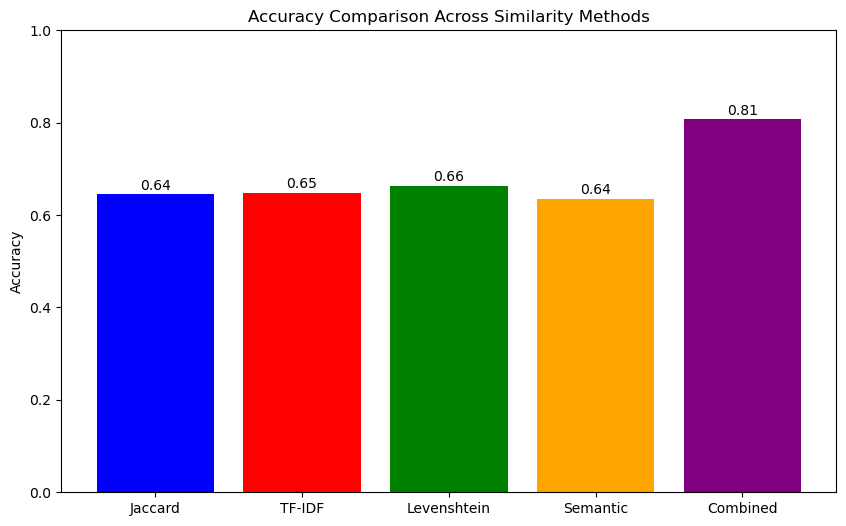

In [10]:
# -----------------------
# Accuracy Comparison Plot
# -----------------------
import matplotlib.pyplot as plt

methods = ["Jaccard", "TF-IDF", "Levenshtein", "Semantic", "Combined"]
accuracies = [jaccard_acc, tfidf_acc, levenshtein_acc, semantic_acc, combined_acc]
plt.figure(figsize=(10, 6))
plt.bar(methods, accuracies, color=["blue", "red", "green", "orange", "purple"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Similarity Methods")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center")
plt.show()

In [11]:
# -----------------------
# Sample Prediction Function
# -----------------------
def predict_similarity(q1, q2, threshold=0.5):
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    feat = [
        TraditionalSimilarity().jaccard_similarity(q1_processed, q2_processed),
        TraditionalSimilarity().tfidf_cosine_similarity(q1_processed, q2_processed),
        TraditionalSimilarity().levenshtein_similarity(q1_processed, q2_processed),
        AIEnhancedSimilarity().semantic_similarity(q1_processed, q2_processed)
    ]
    feat_scaled = scaler.transform([feat])
    pred = clf.predict(feat_scaled)[0]
    proba = clf.predict_proba(feat_scaled)[0][1]
    return pred, proba

In [12]:
# -----------------------
# Example Usage
# -----------------------
q1_sample = "How does a long distance relationship work?"
q2_sample = "How are long distance relationships maintained?"
prediction, probability = predict_similarity(q1_sample, q2_sample)
print(f"\nSample Prediction:")
print(f"Question 1: {q1_sample}")
print(f"Question 2: {q2_sample}")
print(f"Predicted as duplicate (1 = yes): {prediction} with probability {probability:.2f}")



Sample Prediction:
Question 1: How does a long distance relationship work?
Question 2: How are long distance relationships maintained?
Predicted as duplicate (1 = yes): 1 with probability 0.72


c:\Users\heman\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
from flask import Flask, request, render_template_string
import threading

# Assuming necessary imports for prediction function are here
# For example:
# from your_model import TraditionalSimilarity, AIEnhancedSimilarity, preprocess_text, scaler, clf

app = Flask(__name__)

# Sample Prediction Function
def predict_similarity(q1, q2, threshold=0.5):
    # Preprocess the text (assumed to be your preprocessing function)
    q1_processed = preprocess_text(q1)
    q2_processed = preprocess_text(q2)
    
    # Calculate traditional and AI-based similarity scores
    feat = [
        TraditionalSimilarity().jaccard_similarity(q1_processed, q2_processed),
        TraditionalSimilarity().tfidf_cosine_similarity(q1_processed, q2_processed),
        TraditionalSimilarity().levenshtein_similarity(q1_processed, q2_processed),
        AIEnhancedSimilarity().semantic_similarity(q1_processed, q2_processed)
    ]
    
    # Scale features
    feat_scaled = scaler.transform([feat])
    
    # Predict and get probability
    pred = clf.predict(feat_scaled)[0]
    proba = clf.predict_proba(feat_scaled)[0][1]
    
    # Determine result based on the threshold
    if proba >= threshold:
        return pred, proba
    else:
        return 0, proba  # Return 0 (not matched) if the probability is below threshold

@app.route("/", methods=["GET", "POST"])
def index():
    result = ""
    if request.method == "POST":
        user_q1 = request.form.get("question1")
        user_q2 = request.form.get("question2")
        
        # Call the prediction function
        pred, proba = predict_similarity(user_q1, user_q2)
        
        # Determine the result message based on the prediction
        result = "✅ Matched (Duplicate)" if pred == 1 else "❌ Not Matched"
        result += f" with probability {proba:.2f}"
    
    # Reset the result if form was reset (GET method)
    if request.method == "GET":
        result = ""

    html = """
    <!doctype html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        <title>Quora Question Pair Similarity</title>
        <link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css">
        <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
        <style>
            body {
                background-color: #f8f9fa;
                font-family: 'Arial', sans-serif;
            }
            .container {
                max-width: 600px;
                background: white;
                padding: 25px;
                margin-top: 50px;
                border-radius: 10px;
                box-shadow: 0px 0px 20px rgba(0,0,0,0.2);
                animation: fadeIn 1s ease-in-out;
            }
            @keyframes fadeIn {
                from { opacity: 0; transform: translateY(-20px); }
                to { opacity: 1; transform: translateY(0); }
            }
            .btn-custom {
                width: 100%;
                background-color: #007bff;
                color: white;
                border-radius: 5px;
                padding: 10px;
                transition: 0.3s;
            }
            .btn-custom:hover {
                background-color: #0056b3;
            }
            .btn-secondary {
                width: 100%;
                background-color: #6c757d;
                color: white;
                border-radius: 5px;
                padding: 10px;
                transition: 0.3s;
            }
            .btn-secondary:hover {
                background-color: #5a6268;
            }
            .form-control {
                padding: 10px;
                font-size: 16px;
                border-radius: 5px;
            }
            .result {
                text-align: center;
                font-size: 20px;
                margin-top: 20px;
                padding: 10px;
                border-radius: 8px;
                background: #d4edda;
                color: #155724;
                border: 1px solid #c3e6cb;
                animation: slideIn 0.5s ease-in-out;
            }
            @keyframes slideIn {
                from { opacity: 0; transform: scale(0.9); }
                to { opacity: 1; transform: scale(1); }
            }
        </style>
    </head>
    <body>
        <div class="container">
            <h3 class="text-center text-primary">
                AI-Assisted Quora Question Pair Similarity Evaluation
            </h3>
            <p class="text-center text-muted">
                Using <strong>ALL-MPNET-BASE-V2</strong> Model
            </p>
            <form method="post">
                <div class="mb-3">
                    <label for="question1" class="form-label">Question 1:</label>
                    <input type="text" class="form-control" id="question1" name="question1" required>
                </div>
                <div class="mb-3">
                    <label for="question2" class="form-label">Question 2:</label>
                    <input type="text" class="form-control" id="question2" name="question2" required>
                </div>
                <button type="submit" class="btn btn-custom">Predict Duplicate</button>
                <button type="reset" class="btn btn-secondary" onclick="resetForm()">Reset</button>
            </form>
            
            {% if result %}
                <div class="result mt-3">
                    Result: {{ result | safe }}
                </div>
            {% endif %}
        </div>
        <script>
            function resetForm() {
                document.getElementById("question1").value = '';
                document.getElementById("question2").value = '';
                document.querySelector('.result').style.display = 'none';  // Hide result div
            }
        </script>
    </body>
    </html>
    """
    return render_template_string(html, result=result)

# Function to run Flask app in a thread
def run_flask():
    app.run(host="127.0.0.70", port=5000, debug=False, use_reloader=False)

# Run Flask app in a separate thread
thread = threading.Thread(target=run_flask)
thread.start()

 * Serving Flask app '__main__'


 * Debug mode: off


 * Running on http://127.0.0.70:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Apr/2025 19:19:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Apr/2025 19:20:11] "GET /favicon.ico HTTP/1.1" 404 -
c:\Users\heman\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
127.0.0.1 - - [15/Apr/2025 19:20:31] "POST / HTTP/1.1" 200 -
c:\Users\heman\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
127.0.0.1 - - [15/Apr/2025 19:22:36] "POST / HTTP/1.1" 200 -
